In [1]:
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
#!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/volumedata.tif
#!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/results_test.tif

--2023-04-24 01:40:01--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) [application/octet-stream]
Saving to: ‘training.tif’

training.tif        100%[===================>] 123.90M  1.27MB/s    in 2m 9s   

2023-04-24 01:42:11 (984 KB/s) - ‘training.tif’ saved [129919357/129919357]

--2023-04-24 01:42:11--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) 

In [2]:
!pip install segmentation-models 
!pip install patchify
!pip install tensorflow-gpu

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# from tensorflow import keras
import segmentation_models as sm

import glob


import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

!pip install multipagetiff
import multipagetiff as mtif # in order to make small patches out of big images, I used multipagetiff 
from matplotlib import pyplot as plt


from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
patch_size = 256 # the size of patches

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Segmentation Models: using `tf.keras` framework.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# load the Data from google drive
img = mtif.read_stack("/content/training.tif", units='um')
msk = mtif.read_stack("/content/training_groundtruth.tif", units='um')

In [4]:

image_dataset = []  # preparing dataset(images) 
total_count = 500 
count=0
for k in range(img.shape[0]):

  patches_img = patchify(img[k,:,:], (patch_size, patch_size), step=patch_size)  # extracing patches with no overlap
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      if count < total_count:
        single_patch_img = patches_img[i,j,:,:]

        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        gray_three = cv2.merge([single_patch_img,single_patch_img,single_patch_img])

        image_dataset.append(gray_three)
      
      else:
        break
      count+=1

        
count=0
mask_dataset = []   # preparing dataset(masks) 
for k in range(msk.shape[0]):
  patches_mask = patchify(msk[k,:,:], (patch_size, patch_size), step=patch_size)  # extracing patches with no overlap
  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
      if count < total_count:
        
        single_patch_mask = patches_mask[i,j,:,:]
        mask_dataset.append(single_patch_mask)
      else:
        break
      count+=1


'''#Normalize images  ''' # these data are already normalized but this step is crucial 
image_dataset = np.array(image_dataset)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.


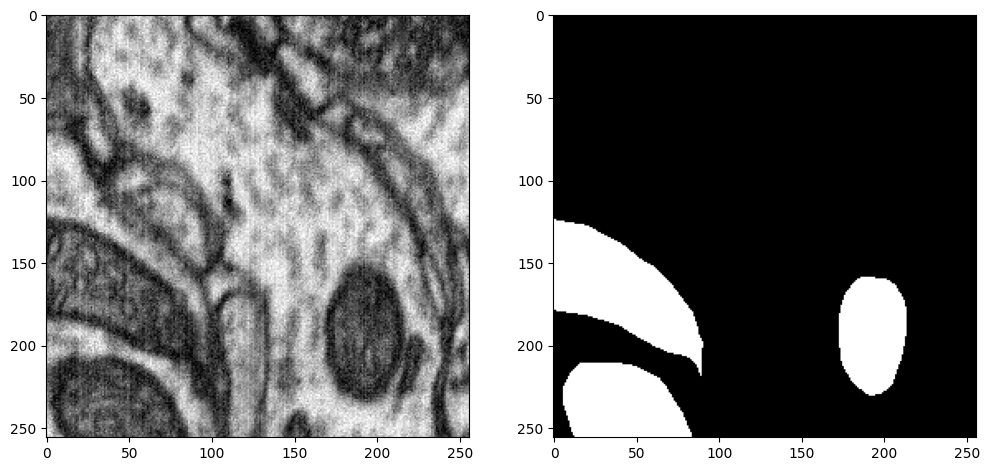

In [5]:
#Sanity check, to check if images and masks are matching 
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size)), cmap='gray')
plt.show() 

In [6]:
#Function to define border. 
#Just erode some pixels into objects and dilate tooutside the objects. 
#This region would be the border. Replace border pixel value to something other than 255. 
def generate_border(image, border_size=5, n_erosions=1):

    erosion_kernel = np.ones((3,3), np.uint8)      ## Start by eroding edge pixels
    eroded_image = cv2.erode(image, erosion_kernel, iterations=n_erosions)  
 
    ## Define the kernel size for dilation based on the desired border size (Add 1 to keep it odd)
    kernel_size = 2*border_size + 1 
    dilation_kernel = np.ones((kernel_size, kernel_size), np.uint8)   #Kernel to be used for dilation
    dilated  = cv2.dilate(eroded_image, dilation_kernel, iterations = 1)
    #plt.imshow(dilated, cmap='gray')
    
    ## Replace 1 values to .5 for all pixels. Eventually we will only define border pixels with this value
    dilated_127 = np.where(dilated == 1, .5, dilated) 	
    
    #In the above dilated image, convert the eroded object parts to pixel value 1
    #What's remaining with a value of .5 would be the boundary pixels. 
    original_with_border = np.where(eroded_image > .5, 1, dilated_127)
    
    #plt.imshow(original_with_border,cmap='gray')
    
    return original_with_border

In [7]:
mask_dataset_border = []   # border dataset
for k in range(mask_dataset.shape[0]):
  single_border_mask = generate_border(mask_dataset[k,:,:,:], border_size=5, n_erosions=1)
  mask_dataset_border.append(single_border_mask)

mask_dataset_border = np.expand_dims((np.array(mask_dataset_border)),3) 
mask_dataset_border.shape

(500, 256, 256, 1)

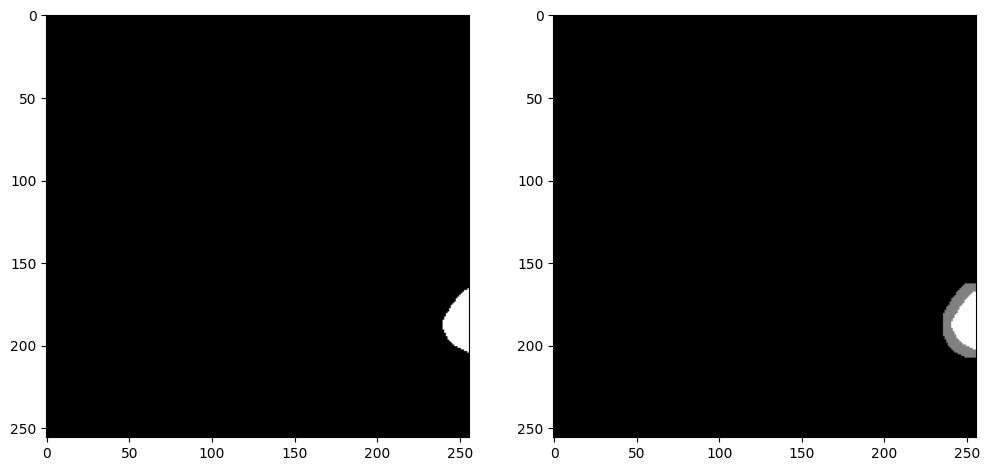

In [8]:
#Sanity check, to check if images and masks are matching 
image_number = random.randint(0, len(mask_dataset_border))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset_border[image_number], (patch_size, patch_size)), cmap='gray')
plt.show() 

In [9]:
import tensorflow as tf

from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU

import tensorflow.keras as keras
print(tf.__version__)
print(keras.__version__)


2.12.0
2.12.0


In [10]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w, k = mask_dataset_border.shape
train_masks_reshaped = mask_dataset_border.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)
# train_masks_input.shape

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [11]:
#################################################
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 20% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, train_masks_input, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2]


In [12]:
n_classes=3 #Number of classes for segmentation

from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print(y_train_cat.shape)
print(y_test_cat.shape)

(400, 256, 256, 3)
(100, 256, 256, 3)


In [13]:
######################################################
#Reused parameters in all models for experimenting with different models
#which is a pretty standard routine

n_classes=3
activation='softmax' #since it is a multi-class segmentation

LR = 0.0001 #the learning rate( 0.0001 its a good starting point)
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [14]:
########################################################################
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [15]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=100,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('content/mito_res34_backbone_100epochs_with_border.hdf5')
############################################################

Epoch 1/100
50/50 [==============================] - 66s 460ms/step - loss: 0.9869 - iou_score: 0.1384 - f1-score: 0.2089 - val_loss: 0.9644 - val_iou_score: 0.1289 - val_f1-score: 0.1859
Epoch 2/100
50/50 [==============================] - 22s 448ms/step - loss: 0.9226 - iou_score: 0.4784 - f1-score: 0.5931 - val_loss: 0.9668 - val_iou_score: 0.0653 - val_f1-score: 0.1091
Epoch 3/100
50/50 [==============================] - 19s 391ms/step - loss: 0.8902 - iou_score: 0.6710 - f1-score: 0.7691 - val_loss: 0.9530 - val_iou_score: 0.2276 - val_f1-score: 0.2705
Epoch 4/100
50/50 [==============================] - 19s 376ms/step - loss: 0.8701 - iou_score: 0.7307 - f1-score: 0.8182 - val_loss: 0.9478 - val_iou_score: 0.2599 - val_f1-score: 0.2932
Epoch 5/100
50/50 [==============================] - 18s 371ms/step - loss: 0.8545 - iou_score: 0.7671 - f1-score: 0.8475 - val_loss: 0.9793 - val_iou_score: 0.1257 - val_f1-score: 0.1982
Epoch 6/100
50/50 [==============================] - 18s 361

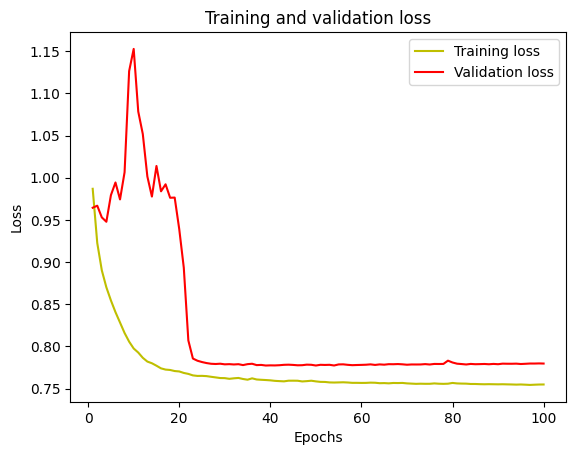

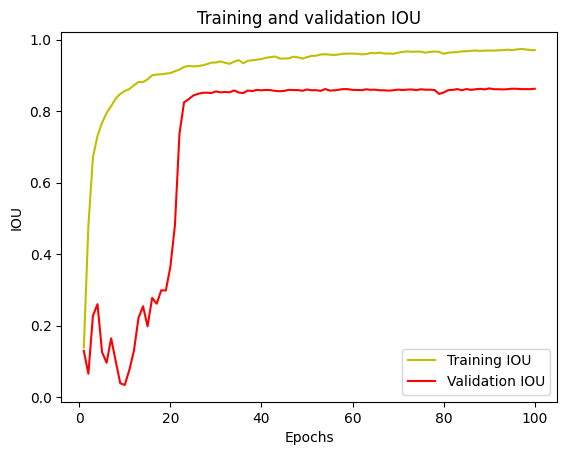

In [16]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [17]:
#####################################################

from tensorflow.keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('content/mito_res34_backbone_100epochs_with_border.hdf5', compile=False)


1/1 [==============================] - 0s 28ms/step


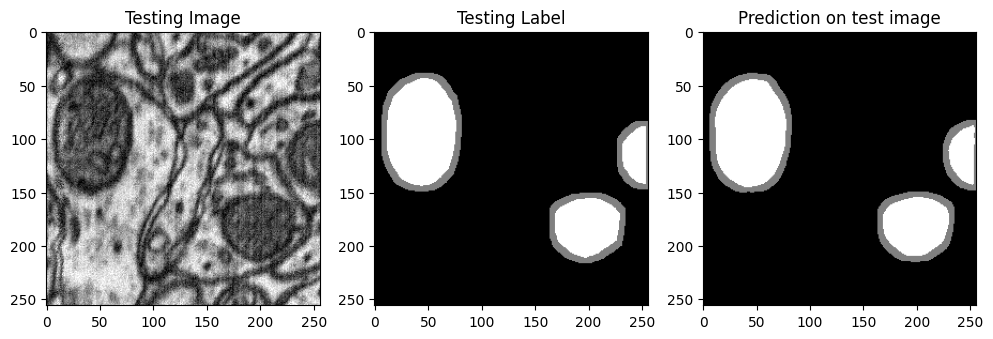

In [22]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [27]:
"""
Prediction followed by watershed.
"""

import segmentation_models as sm

#from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
# ########################################################################
# ###Model 1
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

model = load_model('content/mito_res34_backbone_100epochs_with_border.hdf5', compile=False)


1/1 [==============================] - 0s 28ms/step


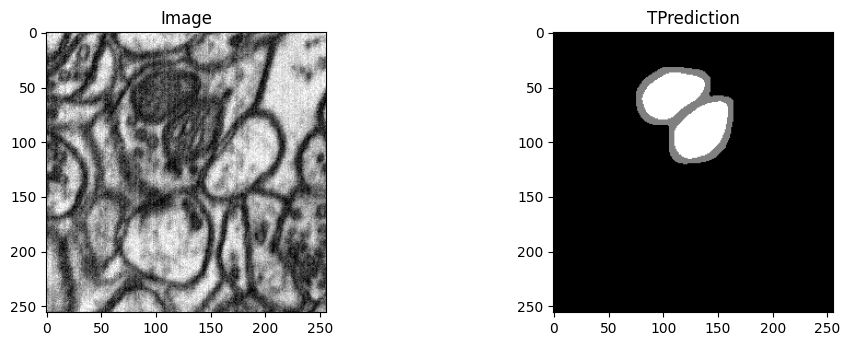

In [146]:
##############################################

#Test some random single small images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
# test_img = cv2.imread('data/test_images/img242.tif', 1)

test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(222)
plt.title('TPrediction')
plt.imshow(test_prediction1[:,:], cmap='gray')
plt.show()

[0 1]


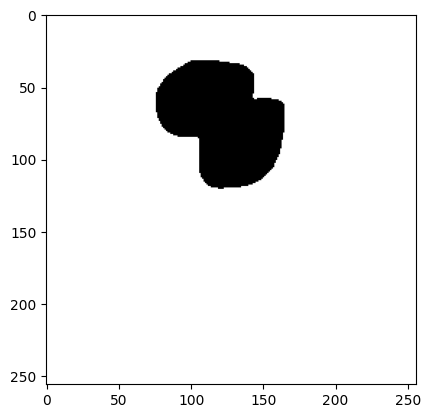

In [147]:
######################################################

#Watershed
from skimage import measure, color

sure_bg = (test_prediction1 == 0).astype(np.uint8)
plt.imshow(sure_bg, cmap='gray')
print(np.unique(sure_bg))  #Background will be pixel value 1


[0 1]


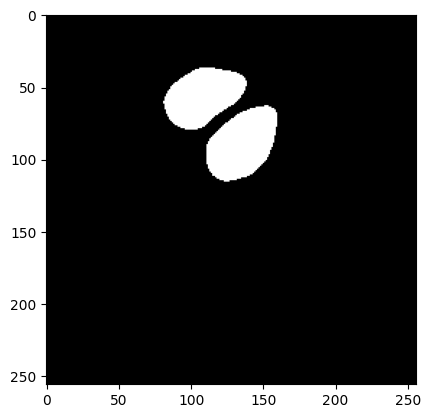

In [148]:

sure_fg = (test_prediction1 == 2).astype(np.uint8)
plt.imshow(sure_fg, cmap='gray')
print(np.unique(sure_fg))  #Foreground will be pixel value 1. Need to change so we can separate from background
sure_fg[sure_fg==1]=2  #Replace values 1 with 2. to not make confusion



[0 1]


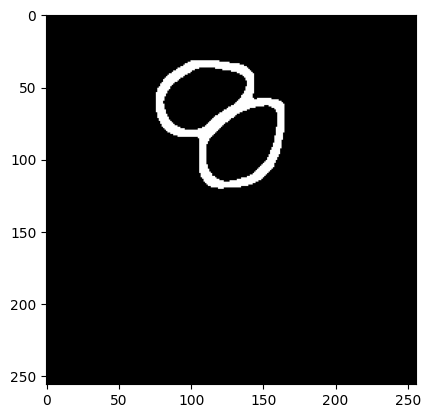

In [149]:
unknown = (test_prediction1 == 1).astype(np.uint8)# the unknown region
plt.imshow(unknown, cmap='gray')
print(np.unique(unknown))

[0 1 2]


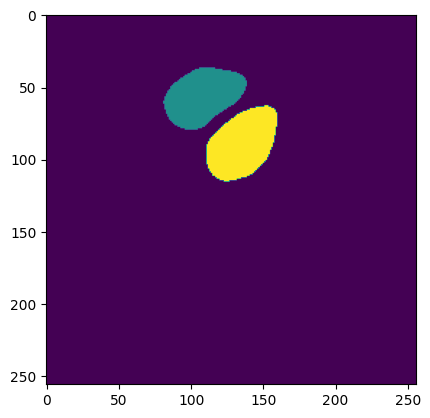

In [150]:
#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 

#For markers let us use ConnectedComponents. 
ret3, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers)
print(np.unique(markers))


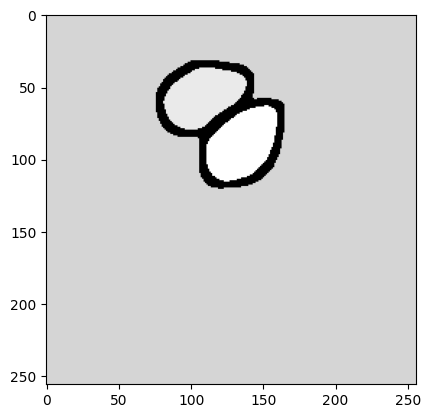

In [151]:
#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==1] = 0
plt.imshow(markers, cmap='gray')   #Look at the 3 distinct regions.


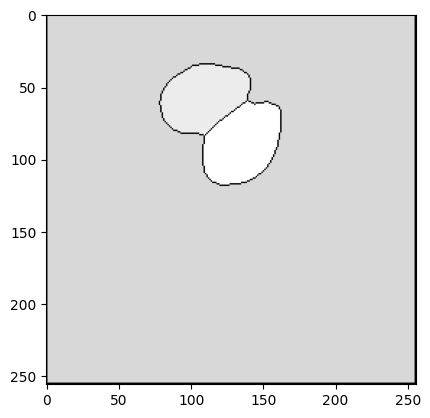

In [152]:
#Now we are ready for watershed filling. 
test_img1 = test_img.astype(np.uint8) 
markers = cv2.watershed(test_img1, markers)
plt.imshow(markers, cmap='gray')
#The boundary region will be marked -1
#https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

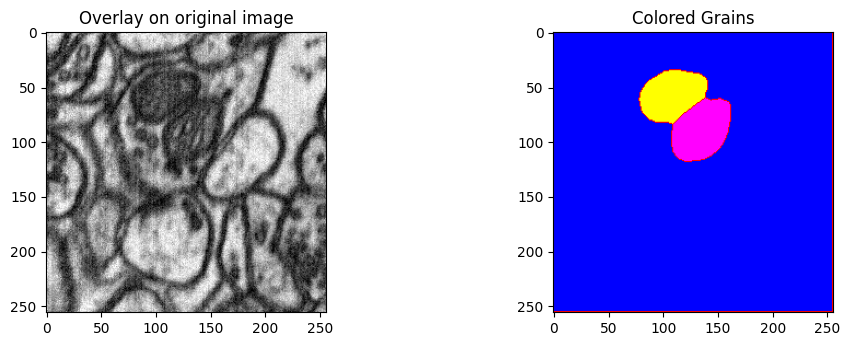

In [159]:
#Let us color boundaries in yellow. 
#test_prediction1[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Overlay on original image')
plt.imshow(test_img, cmap='gray')
plt.subplot(222)
plt.title('Colored Grains')
plt.imshow(img2, cmap='gray')
plt.show()


In [160]:
#Now, time to extract properties of detected cells
# regionprops function in skimage measure module calculates useful parameters for each object.

props = measure.regionprops_table(markers, intensity_image=test_img, 
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])
    
import pandas as pd
df = pd.DataFrame(props)
df = df[df.equivalent_diameter > 20]  #Remove background or other regions that may be counted as objects
df = df[df.equivalent_diameter < 100]

print(df.head())


   label  area  equivalent_diameter  mean_intensity-0  mean_intensity-1  \
1     11  2158            52.418040          0.244778          0.244778   
2     12  2291            54.009183          0.276250          0.276250   

   mean_intensity-2  solidity  
1          0.244778  0.966413  
2          0.276250  0.974894  
